In [ ]:
%cd /content/drive/MyDrive/Hack4Good

/content/drive/MyDrive/Hack4Good


In [ ]:
import os
import cv2
import numpy as np
from imutils import paths
#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import libraries for visualization of data
import matplotlib.pyplot as plt
#import sklearn for preprocessing of data and calculating evaluation metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline

In [ ]:
#Defining various classes
classes=[ 'glass','cardboard', 'metal', 'plastic','paper', 'trash']

DATASET_PATH = "Dataset"

#Spilting dataset
Train_Split=0.85
Val_Split=0.1
Test_Split=0.15
# batch_size = 16 * tpu_strategy.num_replicas_in_sync

imagePaths = list(paths.list_images(DATASET_PATH))
print(imagePaths)
data = []
labels = []

#Processing Images
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[1]
    # print(label)
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)

print(labels)

['Dataset/glass/glass284.jpg', 'Dataset/glass/glass387.jpg', 'Dataset/glass/glass136.jpg', 'Dataset/glass/glass313.jpg', 'Dataset/glass/glass153.jpg', 'Dataset/glass/glass15.jpg', 'Dataset/glass/glass184.jpg', 'Dataset/glass/glass238.jpg', 'Dataset/glass/glass79.jpg', 'Dataset/glass/glass104.jpg', 'Dataset/glass/glass103.jpg', 'Dataset/glass/glass431.jpg', 'Dataset/glass/glass171.jpg', 'Dataset/glass/glass128.jpg', 'Dataset/glass/glass17.jpg', 'Dataset/glass/glass403.jpg', 'Dataset/glass/glass26.jpg', 'Dataset/glass/glass268.jpg', 'Dataset/glass/glass54.jpg', 'Dataset/glass/glass479.jpg', 'Dataset/glass/glass124.jpg', 'Dataset/glass/glass334.jpg', 'Dataset/glass/glass274.jpg', 'Dataset/glass/glass60.jpg', 'Dataset/glass/glass482.jpg', 'Dataset/glass/glass245.jpg', 'Dataset/glass/glass169.jpg', 'Dataset/glass/glass480.jpg', 'Dataset/glass/glass474.jpg', 'Dataset/glass/glass251.jpg', 'Dataset/glass/glass443.jpg', 'Dataset/glass/glass281.jpg', 'Dataset/glass/glass335.jpg', 'Dataset/glass/

In [ ]:
#Processing Data
data = np.array(data)
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=Test_Split, random_state=42,stratify=labels )
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)
# take the validation split from the training split
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY,
    test_size=Val_Split, random_state=84,stratify=trainY)
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

(2147, 224, 224, 3)
(380, 224, 224, 3)
(2147, 6)
(380, 6)
(1932, 224, 224, 3)
(1932, 6)
(215, 224, 224, 3)
(215, 6)


In [ ]:
import pandas as pd
def counter(trainY):
  dt=pd.DataFrame(trainY)
  return dt.value_counts()
print(counter(trainY))

0  1  2  3  4  5
0  0  0  1  0  0    455
   1  0  0  0  0    383
   0  0  0  1  0    369
      1  0  0  0    313
1  0  0  0  0  0    308
0  0  0  0  0  1    104
dtype: int64


In [ ]:
#Data Balancing

from imblearn.over_sampling import SMOTE
    
sm = SMOTE(random_state=42,k_neighbors=2)
    
train_rows=len(trainX)
X_train = trainX.reshape(train_rows,-1)
trainX, trainY = sm.fit_resample(X_train, trainY)
trainX = trainX.reshape(-1,224,224,3) 
print(counter(trainY))

0  1  2  3  4  5
1  0  0  0  0  0    455
0  1  0  0  0  0    455
   0  1  0  0  0    455
      0  1  0  0    455
         0  1  0    455
            0  1    455
dtype: int64


In [ ]:
# set the input image size for proposed CNN model
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# import the VGG16 model with pre-trained weights
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, 
                                        include_top=False,
                                        weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# summary of convolution base of VGG16 model
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Initialize a sequential model to group a linear stack of layers
model = Sequential()

# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated 
# during training inorder to extract features
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2)) 
# # add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function

model.add(Dropout(0.4)) # applies dopout to the input which will randomly disable 40% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions

# compile the built CNN model by selecting suitable optimizer and loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cb=EarlyStopping(monitor = 'val_loss',
                           patience = 4,
                           restore_best_weights = True,
                           mode = 'min')
model_details = model.fit(x=trainX,y=trainY, validation_data=(valX,valY), epochs=20, batch_size=64,callbacks=[cb])

Epoch 1/20
43/43 [==============================] - 83s 1s/step - loss: 7.6483 - accuracy: 0.4322 - val_loss: 1.7966 - val_accuracy: 0.5814
Epoch 2/20
43/43 [==============================] - 24s 571ms/step - loss: 1.5125 - accuracy: 0.6670 - val_loss: 1.2287 - val_accuracy: 0.6372
Epoch 3/20
43/43 [==============================] - 25s 573ms/step - loss: 0.9505 - accuracy: 0.7223 - val_loss: 1.1301 - val_accuracy: 0.6698
Epoch 4/20
43/43 [==============================] - 25s 572ms/step - loss: 0.6981 - accuracy: 0.7813 - val_loss: 1.1374 - val_accuracy: 0.6698
Epoch 5/20
43/43 [==============================] - 25s 573ms/step - loss: 0.5721 - accuracy: 0.8194 - val_loss: 1.0569 - val_accuracy: 0.6884
Epoch 6/20
43/43 [==============================] - 25s 573ms/step - loss: 0.4281 - accuracy: 0.8575 - val_loss: 1.0146 - val_accuracy: 0.6977
Epoch 7/20
43/43 [==============================] - 25s 573ms/step - loss: 0.3616 - accuracy: 0.8832 - val_loss: 0.9313 - val_accuracy: 0.7163
Ep

In [ ]:
#Evalution on testing data
print("Evaluate on test data")
results = model.evaluate(testX, testY, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
12/12 [==============================] - 29s 1s/step - loss: 0.7809 - accuracy: 0.7632
test loss, test acc: [0.7808752655982971, 0.7631579041481018]


In [ ]:
#Evalution on testing data
print("Evaluate on train data")
results = model.evaluate(trainX, trainY, batch_size=32)
print("test loss, test acc:", results)

Evaluate on train data
86/86 [==============================] - 29s 337ms/step - loss: 0.0537 - accuracy: 0.9912
test loss, test acc: [0.05372424051165581, 0.9912087917327881]


In [ ]:
y_pred = model.predict(testX, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
testY = np.argmax(testY, axis=1)
print(classification_report(testY, y_pred_bool))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        61
           1       0.74      0.75      0.74        75
           2       0.74      0.73      0.73        62
           3       0.84      0.81      0.82        89
           4       0.68      0.76      0.72        72
           5       0.63      0.57      0.60        21

    accuracy                           0.76       380
   macro avg       0.75      0.74      0.74       380
weighted avg       0.77      0.76      0.76       380



In [ ]:
model.save('vgg16_smote.h5')

In [ ]:
model = keras.models.load_model('vgg16_smote.h5')

5
98.89057874679565
trash


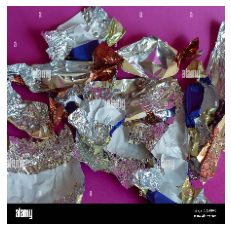

In [ ]:
classes=[ 'glass','cardboard', 'metal', 'plastic','paper', 'trash']
def prepare(filepath):
  image = cv2.imread(filepath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))
  plt.imshow(image)
  plt.axis('off')
  return image.reshape(-1,224,224,3)

prediction=model.predict(prepare("images//trash.jpg"))
# plt.plot("images/trash.jpg")
prediction_index=prediction.argmax()
print(prediction_index)
print(float(prediction[0][prediction_index])*100)
print(classes[prediction_index])